## Tutorial: Random Forest and XGBoost

#### 1 นำเข้าข้อมูล

In [ ]:
# โหลดข้อมูล Churn จาก GitHub
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv') # error_bad_lines=False

เป้าหมายคือการทำนายค่าในคอลัมน์ `Churn`

#### 2 สำรวจข้อมูล

In [ ]:
# ดูข้อมูล 5 แถวแรก
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# ดูข้อมูล 5 แถวสุดท้าย
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [ ]:
# ตรวจสอบการมี missing values ในแต่ละคอลัมน์
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


สังเกตว่าข้อมูลประกอบด้วย 2 รูปแบบ คือ กลุ่มข้อมูลที่เป็นตัวเลข (`int64` และ `float64`) และ กลุ่มข้อมูลที่เป็นนตัวอักษร (`object`) 

ดูค่าสถิติเบื้องต้นของคอลัมน์ที่เป็นตัวเลข (numerical columns)

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


สังเกตว่าการกระจายตัวของ `SeniorCitizen` มีลักษณะแปลก ๆ เนื่องจากค่า `min`, `25%`, `50%`, `75%` และ `max` มีค่าอยู่แค่ `0` และ `1` เท่านั้น ซึ่งลักษณะโดยทั่วไปของคอลัมน์ที่เป็นตัวเลขควรมีการกระจายตัวที่มากกว่านี้ หรือก็คือควรมีค่าที่หลากหลายกว่าเพียงแค่ 0 และ 1 จึงสรุปได้ว่าคอลัมน์นี้เป็นคอลัมน์ที่บอกว่าข้อมูลในแถวนั้นมาจากผู้สูงอายุหรือไม่ (อาจมองว่าเป็นเหมือนสิ่งที่ได้จาก one-hot encoding)

In [ ]:
# โหลด packages ที่ใช้ในการสร้างกราฟ
import matplotlib.pyplot as plt
import seaborn as sns

ดูการกระจายตัวของข้อมูลของ `tenure`

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


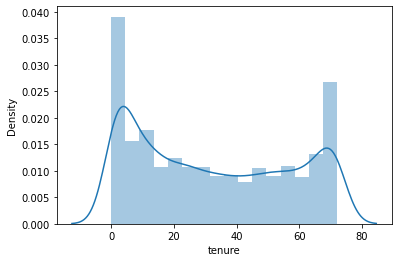

In [ ]:
sns.distplot(df['tenure'])

ดูการกระจายตัวของข้อมูลของ `MonthlyCharges`

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


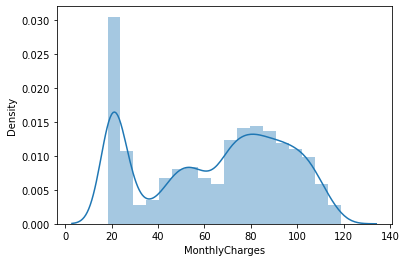

In [ ]:
sns.distplot(df['MonthlyCharges'])

การกระจายตัวของทั้งสองคอลัมน์ค่อนข้างโอเคแล้ว

ดูค่าสถิติเบื้องต้นของคอลัมน์ที่เป็นตัวอักษร (categorical columns)

In [ ]:
df.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,0657-DOGUM,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


มีอะไรบางอย่างเกิดขึ้นในคอลัมน์ `TotalCharges` เพราะว่า unique values มีถึง 6531 ค่า (จากทั้งหมด 7043 ค่า) แต่สำหรับ `customerID` ที่ถึงแม้ว่าจะมี unique values เยอะเช่นกัน แต่ค่าในคอลัมน์นี้จะสื่อถึงความแตกต่างของข้อมูลในแต่ละแถว

In [ ]:
# ใช้คอลัมน์ `customerID` เพื่อตรวจสอบการมีข้อมูลซ้ำ
# ถ้าคำสั่งนี้ให้ค่าเป็น True แสดงว่ามีข้อมูลที่ซ้ำกันอยู่ แต่ถ้า False แสดงว่าไม่มีข้อมูลซ้ำ
df['customerID'].duplicated().any()

False

In [ ]:
# ดูค่าในคอลัมน์ `TotalCharges`
df['TotalCharges']

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

ดูจากค่าในคอลัมน์ที่มีแต่ตัวเลขแล้ว คอลัมน์นี้ควรเป็น `float`

In [ ]:
# แปลงชนิดข้อมูลของคอลัมน์นี้ไปเป็นทศนิยม (float)
df['TotalCharges'].astype(float)

ValueError: ignored

เมื่อทำการแปลงชนิดข้อมูลไปเป็น `float` แล้ว ไม่สามารถแปลงชนิดข้อมูลได้ เนื่องจากในคอลัมน์นี้มีตัวอักษรอยู่ด้วย ซึ่งโดยทั่วไปแล้ว ความผิดพลาดแบบนี้มักเกิดขึ้นจากการที่คอลัมน์นี้มีข้อมูลที่เป็นช่องว่างอยู่

In [ ]:
# แปลงช่องว่างให้เป็น missing values
import numpy as np
df['TotalCharges'].replace(' ', np.nan, inplace=True)

In [ ]:
# ตัดข้อมูลที่เป็น missing values
df = df[~pd.isnull(df['TotalCharges'])] # ถ้าหากมีปัญหาในการพิมพ์ tilde อาจใช้คำสั่ง df = df[df['TotalCharges'].notnull()]

# ปรับ index ของข้อมูลหลังจากการตัดข้อมูล
df.reset_index(drop=True, inplace=True)

In [ ]:
# แปลงข้อมูลในคอลัมน์ TotalCharges ให้เป็น float
df['TotalCharges'] = df['TotalCharges'].astype(float)

พิจารณาค่าในคอลัมน์ที่เหลือ

In [ ]:
# สร้าง list ไว้เก็บชื่อคอลัมน์ เพื่อใช้งานตอนหลัง
cat_col = []

# สร้างลูปรันสำหรับทุกคอลัมน์ใน df
for col in df.columns:
  # เนื่องจากดูไปแล้ว 5 คอลัมน์ จะดูคอลัมน์ที่เหลือ
  if col not in ['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']:  
    cat_col.append(col)
    print(col)
    print(df[col].value_counts())
    print('\n\n\n')

gender
Male      3549
Female    3483
Name: gender, dtype: int64




Partner
No     3639
Yes    3393
Name: Partner, dtype: int64




Dependents
No     4933
Yes    2099
Name: Dependents, dtype: int64




PhoneService
Yes    6352
No      680
Name: PhoneService, dtype: int64




MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64




InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64




OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64




OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64




DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64




TechSupport
No                     3472
Yes                    2040

สังเกตว่าค่าในคอลัมน์ `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` และ `StreamingMovies` จะมี 3 กลุ่ม ได้แก่ `Yes`, `No` และ `No internet service` ซึ่ง `No` และ `No internet service` อาจเข้าใจว่าเป็นกลุ่มเดียวกันก็ได้

In [ ]:
col_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[col_to_replace] = df[col_to_replace].replace('No internet service', 'No')

แปลงค่าในคอลัมน์ `Contract` โดยการใช้ ordinal encoding

In [ ]:
# สร้าง dictionary สำหรับแปลงค่า โดยให้ค่าเดิมเป็น key และค่าใหม่เป็น value
replace_dict = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df.replace({'Contract': replace_dict}, inplace=True)

แปลงค่าในคอลัมน์ `Churn` โดย `Yes` ให้เป็น `1` และ `No` ให้เป็น `0`

In [ ]:
df.replace({'Churn': {'Yes': 1, 'No': 0}}, inplace=True)

แปลงค่าใน categorical columns อื่น ๆ โดยการใช้ one-hot encoding

In [ ]:
# ใช้ drop_first=True เพื่อให้ตัดกลุ่ม 1 กลุ่มออกไปจากคอลัมน์ 
# เนื่องจากว่าหากทราบว่าข้อมูลในคอลัมน์นี้ประกอบด้วย 3 กลุ่ม 
# และข้อมูลที่สนใจไม่อยู่ใน 2 กลุ่มแล้ว สามารถสรุปได้ว่าข้อมูลดังกล่าวต้องอยู่อีกกลุ่มหนึ่งอย่างแน่นอน
df = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)

In [ ]:
df

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,29.85,29.85,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,0,34,1,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,0,2,0,53.85,108.15,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1
3,0,45,1,42.30,1840.75,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0
4,0,2,0,70.70,151.65,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,24,1,84.80,1990.50,0,1,1,1,1,0,1,0,0,1,0,1,1,1,1,1,0,0,1
7028,0,72,1,103.20,7362.90,0,0,1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0
7029,0,11,0,29.60,346.45,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
7030,1,4,0,74.40,306.60,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1


#### 3 เตรียมความพร้อมข้อมูล

แบ่งข้อมูลออกเป็น 2 ส่วน ได้แก่ ส่วนที่สร้างโมเดล (training set) และส่วนที่ทดสอบโมเดล (test set) ด้วยอัตราส่วน 7:3

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.3, random_state=2020)

ปรับค่า numerical columns ให้มีค่าอยู่ในช่วงตั้งแต่ 0 ถึง 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# กำหนดตัวแปลงค่า ซึ่งจะแปลงให้ค่าข้อมูลไปอยู่ในช่วงตั้งแต่ 0 ถึง 1
scaler = MinMaxScaler()

# ต้องการปรับค่าเฉพาะ numerical columns เท่านั้น นั่นคือ tenure และ MonthlyCharges
# โดยให้ปรับค่าจาก training data และใช้ตัวแปลงค่าเดิมไปปรับค่าใน test data
# ทำให้ต้องใช้คำสั่ง fit_transform สำหรับ X_train และใช้คำสั่ง transform สำหรับ X_test
X_train.loc[:, ['tenure', 'MonthlyCharges']] = scaler.fit_transform(X_train.loc[:, ['tenure', 'MonthlyCharges']])
X_test.loc[:, ['tenure', 'MonthlyCharges']] = scaler.transform(X_test.loc[:, ['tenure', 'MonthlyCharges']])

#### 4 นำข้อมูลเข้าโมเดล

In [ ]:
# ในตัวอย่างนี้จะพิจารณา 4 โมเดล
classifiers = {}

โมเดลที่ 1 [Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
from sklearn.linear_model import LogisticRegression

classifiers['lr'] = LogisticRegression()

โมเดลที่ 2 [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifiers['dt'] = DecisionTreeClassifier()

โมเดลที่ 3 [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifiers['rf'] = RandomForestClassifier()

โมเดลที่ 4 [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [ ]:
import xgboost as xgb

classifiers['xg'] = xgb.XGBClassifier()

เทรนโมเดล

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
def prec_recall_ROC_plot(clf,X_test):
  '''
  clf คือ โมเดลที่ใช้
  ฟังก์ชันนี้จะแสดงค่าพล็อตกราฟของ precision และ recall ที่ threshold ต่าง ๆ และ ROC
  '''
  # ทำนายค่าของ test data
  y_score = clf.predict_proba(X_test)

  # คำนวณค่า average precision
  print('avg. precision: %.2f' % average_precision_score(y_test, y_score[:, 1]))
  
  # คำนวณค่า precision, recall (true positive rate, TPR) และ false positive rate (FPR) ที่ threshold ต่าง ๆ
  precision, recall, threshold = precision_recall_curve(y_test, y_score[:, 1])
  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
  roc_auc = auc(fpr, tpr)

  # พล็อตกราฟ
  plt.figure(figsize=(18, 4))

  # precision and recall
  plt.subplot(131)
  plt.plot(threshold, precision[:-1], color='darkorange', lw=2, label='precision')
  plt.plot(threshold, recall[:-1], color='navy', lw=2, label='recall')
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('Threshold')
  plt.title('Precision and recall vs threshold')
  plt.legend(loc='lower left')
    
  # ROC
  plt.subplot(132)
  plt.plot(fpr, tpr, color='black', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.show()

Logistic regression
accuray score: 0.80
avg. precision: 0.64


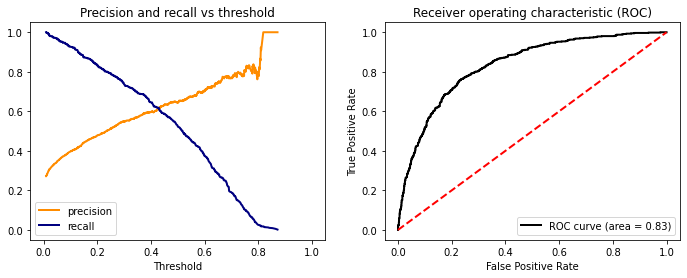





Decision tree
accuray score: 0.73
avg. precision: 0.38


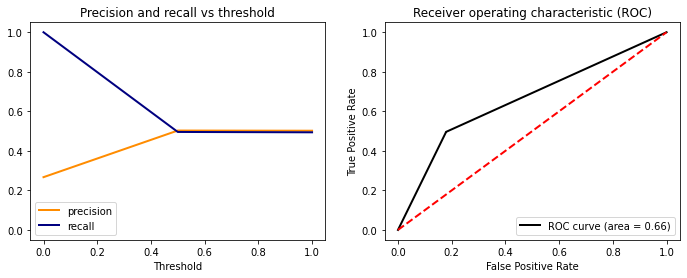





Random forest
accuray score: 0.79
avg. precision: 0.62


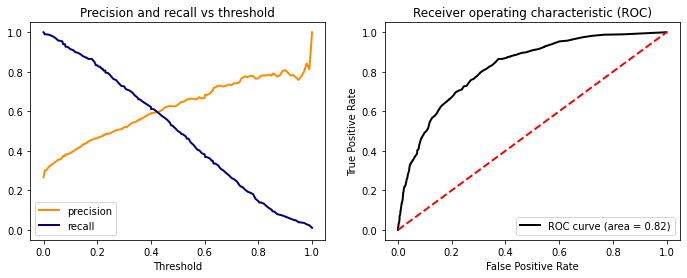





XGBoost
accuray score: 0.80
avg. precision: 0.65


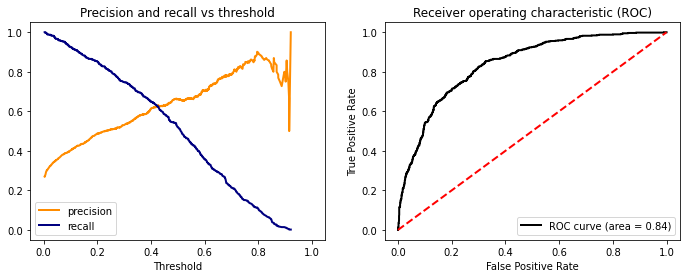

In [ ]:
from sklearn.metrics import accuracy_score,average_precision_score
# สร้าง dictionary สำหรับอธิบายตัวย่อของแต่ละโมเดล
model_description = {'lr': 'Logistic regression', 'dt': 'Decision tree', 'rf': 'Random forest', 'xg': 'XGBoost'}

# สร้าง loop สำหรับการเทรนและทดสอบโมเดล
for model_name in model_description.keys():
    model = classifiers[model_name]
    #Train the model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(model_description[model_name])
    print("accuray score: %.2f"%accuracy_score(y_test,y_pred))
    prec_recall_ROC_plot(model,X_test)
    print('\n\n\n') #print new lines

#### 5 ปรับแต่งโมเดล

เนื่องจากตอนสร้างโมเดล `classifiers`นั้นเป็นการใช้ default settings ของแต่ละโมเดล ซึ่งในทางปฏิบัติสามารถปรับค่าของ parameter ต่าง ๆ ได้เพื่อให้มีความเหมาะสมกับข้อมูลมากยิ่งขึ้น

สังเกตว่าจากค่า default นั้น model ที่เป็น decision tree ทำงานได้ไม่ดี เราจึงลอง visualize ดู

In [ ]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(classifiers["dt"], out_file=None, 
                              feature_names=X_train.columns,
                              class_names=['0','1'],
                              filled=True, rounded=True,
                              special_characters=True, rotate=True)
graph = graphviz.Source(dot_data)
graph.render('dtree_render',view=True)

'dtree_render.pdf'

ค่อนข้างมีความเป็นไปได้สูงว่าจะ overfit เช็ค precision ของ training set ดู

In [ ]:
dt_score_train = classifiers["dt"].predict_proba(X_train)
# คำนวณค่า average precision
print('avg. precision: %.2f' % average_precision_score(y_train, dt_score_train[:, 1]))
# check accuracy score
print("accuray score: %.2f"%accuracy_score(y_train, classifiers["dt"].predict(X_train)))

avg. precision: 1.00
accuray score: 1.00


Overfit! ถ้าเจอสถานการณ์แบบนี้เราจะอยากที่จะปรับ parameter ให้ มี regularization effect มากขึ้น เช่นลด max_depth ของ Tree ลง

ถ้าจะ tune จริงๆต้องแบ่งเป็น 3 dataset ในกรณีนี้จะแบ่ง training ย่อยลงไปใช้เป็นสำหรับ train/validate

In [ ]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=2020)

In [ ]:
dt_experiment = DecisionTreeClassifier(random_state=2020)
dt_experiment.fit(X_t,y_t)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [ ]:
y_pred_experiment = dt_experiment.predict(X_v)

In [ ]:
#Baseline
dt_score_v=dt_experiment.predict_proba(X_v)
print('avg. precision: %.2f' % average_precision_score(y_v, dt_score_v[:, 1]))
print("accuray score: %.2f"%accuracy_score(y_v,y_pred_experiment))

avg. precision: 0.41
accuray score: 0.74


ปรับค่าจนคิดว่าได้อันที่ดีที่สุดแล้ว (ลองหลายๆค่า)

In [ ]:
dt_experiment = DecisionTreeClassifier(max_depth=7 ,random_state=2020)
dt_experiment.fit(X_t,y_t)
y_pred_experiment = dt_experiment.predict(X_v)
dt_score_v=dt_experiment.predict_proba(X_v)
print('avg. precision: %.2f' % average_precision_score(y_v, dt_score_v[:, 1]))
print("accuray score: %.2f"%accuracy_score(y_v,y_pred_experiment))

avg. precision: 0.58
accuray score: 0.77


เอาไปประเมินครั้งสุดท้ายกับ test set

In [ ]:
#retrain again with the setting found
dt_experiment = DecisionTreeClassifier(max_depth=7 ,random_state=2020)
dt_experiment.fit(X_train,y_train)
y_pred_experiment = dt_experiment.predict(X_test)
dt_score_experiment=dt_experiment.predict_proba(X_test)
print('avg. precision: %.2f' % average_precision_score(y_test, dt_score_experiment[:, 1]))
print("accuray score: %.2f"%accuracy_score(y_test,y_pred_experiment))

avg. precision: 0.58
accuray score: 0.79


ทั้งนี้ การที่เราจะทำการปรับค่าด้วยมือนั้นจะใช้เวลาค่อนข้างมาก การใช้คำสั่งช่วยเสริมอาจจะดีกว่า

GridSearchCV() เป็นคำสังที่จะทำการทดลอง train model ด้วย parameter ต่างๆ train **และ** ทำการ cross-validate เพื่อเลือก parameters ที่ดีที่สุดให้ด้วย

In [ ]:
parameters_choices = {'max_depth': [3, 5, 8],
                     'min_samples_split': [1, 2, 4]}

In [ ]:
dt_tune = DecisionTreeClassifier(random_state=2020)

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_dt = GridSearchCV(estimator=dt_tune, param_grid=parameters_choices, scoring='average_precision', cv=3, n_jobs=-1)

In [ ]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=2020,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'min_s

In [ ]:
#Best Parameters
grid_dt.best_params_

{'max_depth': 5, 'min_samples_split': 2}

สร้าง model ด้วย parameters ที่ดีที่สุด และ train ใหม่

In [ ]:
dt_best = DecisionTreeClassifier(random_state=2020, **grid_dt.best_params_) 
dt_best.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

accuray score: 0.78
avg. precision: 0.60


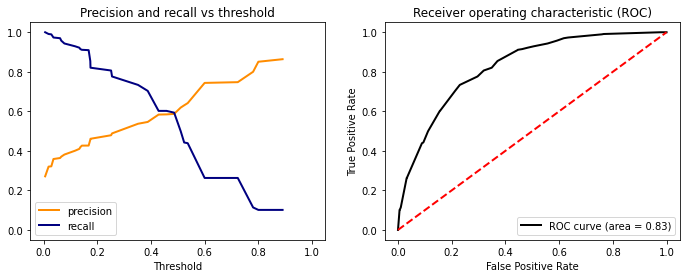

In [ ]:
y_pred = dt_best.predict(X_test)
print("accuray score: %.2f"%accuracy_score(y_test,y_pred))
prec_recall_ROC_plot(dt_best,X_test)

ในกรณีที่เรามีหลายโมเดล เราสามารถใช้วิธีการ loop แล้ว gridsearch หา parameters ที่เหมาะสมของทุกโมเดลได้

***ด้านล่างเป็นตัวอย่างของ code ที่ ได้ทำการ tune model ทุกอัน***

In [ ]:
from sklearn.model_selection import GridSearchCV

# สร้าง dictionary สำหรับเก็บค่า parameters ต่าง ๆ ในโมเดลเพื่อหาค่าที่ดีที่สุด
param_grids = {}

# ตัวอย่างการปรับค่า parameters ใน Logistic regression
param_grids['lr'] = {'C': [0.001*10**i for i in range(6)]}

# ตัวอย่างการปรับค่า parameters ใน Decision tree
param_grids['dt'] = {'max_depth': [3, 5, 8],
                     'min_samples_split': [1, 2, 4]}

# ตัวอย่างการปรับค่า parameters ใน Random forest
param_grids['rf'] = {'n_estimators': [100, 200, 300],
                     'max_depth' : [3, 5, 8]}

# ตัวอย่างการปรับค่า parameters ใน XGBoost
param_grids['xg'] = {'max_depth': [3, 5, 8],
                     'min_child_weight': [1, 2, 4]}

**หมายเหตุ:** สามารถปรับค่า parameters ได้มากกว่านี้

In [ ]:
# กำหนดโมเดลด้วย random_state=2020
classifiers['lr'] = LogisticRegression(random_state=2020)
classifiers['dt'] = DecisionTreeClassifier(random_state=2020)
classifiers['rf'] = RandomForestClassifier(random_state=2020)
classifiers['xg'] = xgb.XGBClassifier(random_state=2020)

# สร้าง dictionary สำหรับเก็บค่าที่ได้จากการหาค่า parameters ที่เหมาะสมที่สุด
grid_searchers = {}

# สร้าง loop สำหรับหาค่า parameters ที่เหมาะสมในแต่ละโมเดล
for model_name in model_description.keys():
  print('คำนวณค่า parameters ที่เหมาะสมสำหรับ %s' % model_description[model_name], end='')

  # ใช้ average precision เป็นตัวชี้วัดประสิทธิภาพของโมเดล
  grid_searchers[model_name] = GridSearchCV(estimator=classifiers[model_name], param_grid=param_grids[model_name], scoring='average_precision', cv=3, n_jobs=-1)
  grid_searchers[model_name].fit(X_train, y_train)
  print(': เสร็จสิ้น')

คำนวณค่า parameters ที่เหมาะสมสำหรับ Logistic regression: เสร็จสิ้น
คำนวณค่า parameters ที่เหมาะสมสำหรับ Decision tree: เสร็จสิ้น
คำนวณค่า parameters ที่เหมาะสมสำหรับ Random forest: เสร็จสิ้น
คำนวณค่า parameters ที่เหมาะสมสำหรับ XGBoost: เสร็จสิ้น


In [ ]:
# แสดงค่า parameters ที่เหมาะสมที่สุดในแต่ละโมเดล
best_params = {}

for model_name in model_description.keys():
  print(model_description[model_name])
  best_params[model_name] = grid_searchers[model_name].best_params_
  print(best_params[model_name], end='\n\n\n')

Logistic regression
{'C': 0.1}


Decision tree
{'max_depth': 5, 'min_samples_split': 2}


Random forest
{'max_depth': 8, 'n_estimators': 300}


XGBoost
{'max_depth': 3, 'min_child_weight': 4}




ทดสอบโมเดลจากการเทรนด้วย parameters ที่เหมาะสมที่สุด

Logistic regression
accuray score: 0.80
avg. precision: 0.64


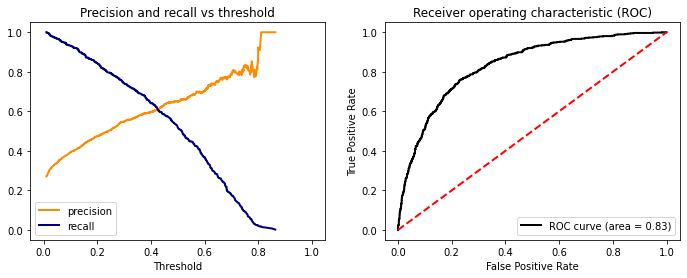





Decision tree
accuray score: 0.78
avg. precision: 0.60


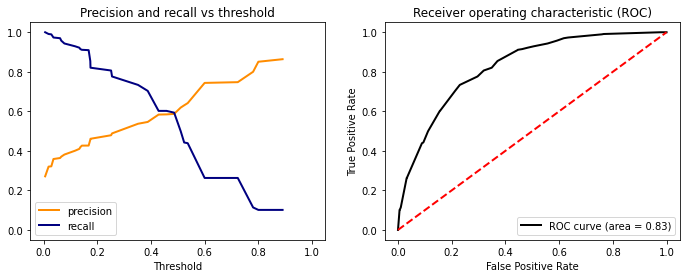





Random forest
accuray score: 0.80
avg. precision: 0.66


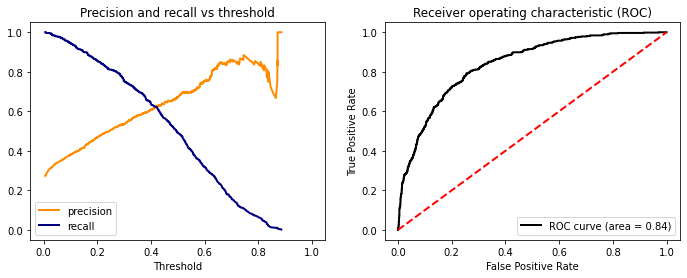





XGBoost
accuray score: 0.80
avg. precision: 0.65


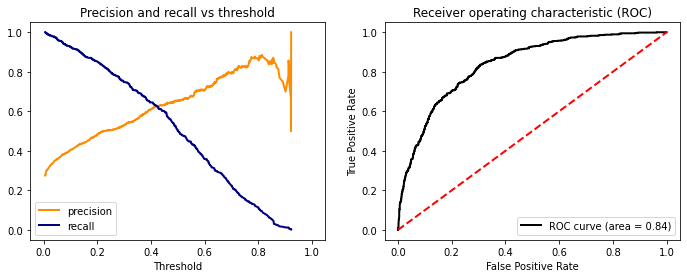

In [ ]:
# กำหนดโมเดลด้วยค่า parameters ที่เหมาะสมที่สุด
# สามารถใช้ `**dictionary` เพื่อเรียกใช้ค่าอยู่ใน dictionary นั้น
classifiers['lr'] = LogisticRegression(random_state=2020, **best_params['lr'])
classifiers['dt'] = DecisionTreeClassifier(random_state=2020, **best_params['dt'])
classifiers['rf'] = RandomForestClassifier(random_state=2020, **best_params['rf'])
classifiers['xg'] = xgb.XGBClassifier(random_state=2020, **best_params['xg'])

# ทดสอบโมเดล
for model_name in model_description.keys():
    model = classifiers[model_name]
    #Train the model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(model_description[model_name])
    print("accuray score: %.2f"%accuracy_score(y_test,y_pred))
    prec_recall_ROC_plot(model,X_test)
    print('\n\n\n') #print new lines

**หมายเหตุ:** ข้อมูลที่ยกตัวอย่างมามีการกระจายตัวระหว่างการเป็น Churn (ํ`Yes` และ `No`) ที่ไม่เท่ากัน ซึ่งเรียกข้อมูลลักษณะนี้ว่า *imbalanced data* และสามารถจัดการให้ข้อมูลเป็น balanced data ก่อนตอนเทรนโมเดลได้ โดยการใช้วิธี under-sampling, over-samping หรือ SMOTE เป็นต้น

In [ ]:
df['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64